# <center>Bike Sharing Demand</center>

### <div align='right'>Filip Kowalski</right>

In [1]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [2]:
# set figure size
plt.rcParams['figure.figsize'] = (10,10)

# Load Data

In [3]:
filename='train.csv'
dataset=read_csv(filename)

# Looking on data 

In [4]:
time=pd.to_datetime(dataset.datetime)
dataset.datetime=time

In [5]:
dataset.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


### Data Fields
<br>
**datetime** - hourly date + timestamp  
**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
<br>
**holiday** - whether the day is considered a holidayr
<br>
**workingday** - whether the day is neither a weekend nor holiday
<br>
**weather**
1. : Clear, Few clouds, Partly cloudy, Partly cloudy 
* : Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
* : Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
* : Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 



**temp** - temperature in Celsius
<br>
**atemp** - "feels like" temperature in Celsius
<br>
**humidity** - relative humidity
<br>
**windspeed** - wind speed
<br>
**casual** - number of non-registered user rentals initiated
<br>
**registered** - number of registered user rentals initiated
<br>
**count** - number of total rentals

In [6]:
print(dataset.shape)

(10886, 12)


# Descriptions of data

In [7]:
print(dataset.describe())

             season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.96047

There is no null values. Data look corect (there is not strange values like negative values or to low or to hight numbers)

In [8]:
bins = pd.cut(dataset['count'], [0, 100, 200,300,400,500,600,700,800,900])
groups=dataset.groupby(bins)['count'].agg(['count', 'sum'])
print(groups)

            count     sum
count                    
(0, 100]     4328  155193
(100, 200]   2356  349165
(200, 300]   1720  423964
(300, 400]   1039  361148
(400, 500]    646  289638
(500, 600]    385  211001
(600, 700]    216  140012
(700, 800]    110   81915
(800, 900]     78   65891


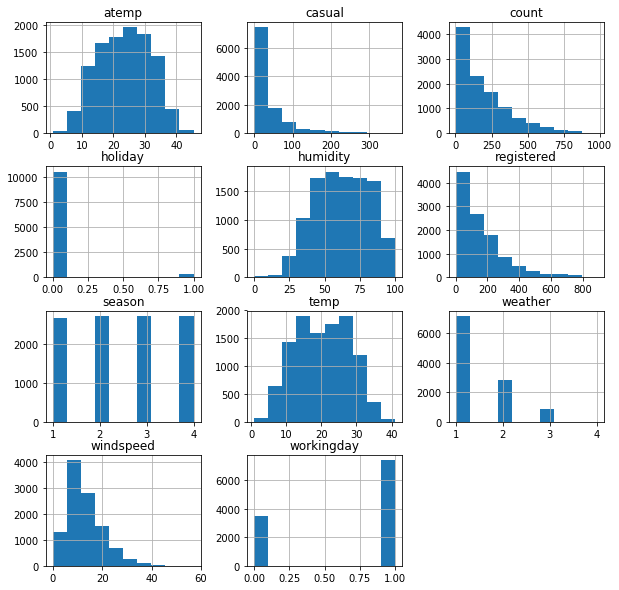

In [9]:
dataset.hist()
plt.show()

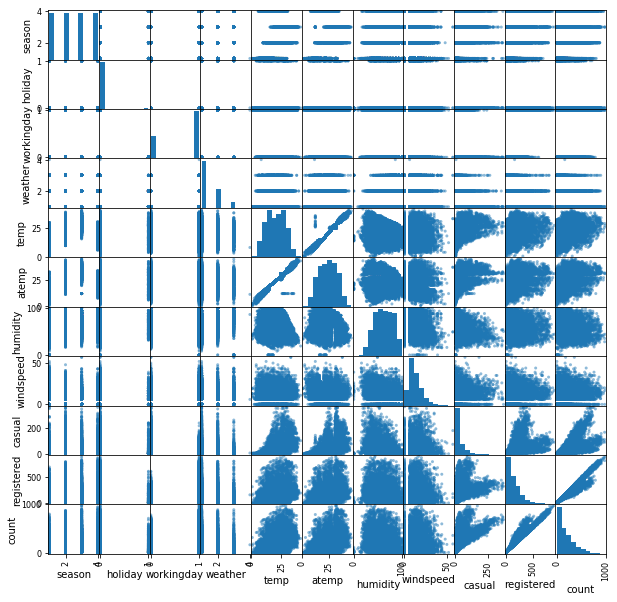

In [10]:
pd.plotting.scatter_matrix(dataset)
plt.show()

## Możemy przyjrzeć się danym. Widać bardzo dobre korelacje pomiędzy registered,casual i count. Jednak w danych testowych nie mamy tych wielkości więc nie możemy ich użyć do tworzenia modelu (jeśli wiemy ilu mamy klientów danego dnia to po co mielibyśmy to prognozować?). 
## Istnieje również korelacjia pomiędzy tempa atemp. Oznacza to, że w kolejnym kroku można zredukować te dwie wielkości do jednej aby poprawić wyniki prognozy. Reszta danych jest silnie nieskorelowana. Widać to zarówno na wykresie jak i w liczbach poniżej.

In [11]:
pd.set_option('precision',2)
print(dataset.corr(method='pearson'))

              season   holiday  workingday   weather      temp     atemp  \
season      1.00e+00  2.94e-02   -8.13e-03  8.88e-03  2.59e-01  2.65e-01   
holiday     2.94e-02  1.00e+00   -2.50e-01 -7.07e-03  2.95e-04 -5.21e-03   
workingday -8.13e-03 -2.50e-01    1.00e+00  3.38e-02  3.00e-02  2.47e-02   
weather     8.88e-03 -7.07e-03    3.38e-02  1.00e+00 -5.50e-02 -5.54e-02   
temp        2.59e-01  2.95e-04    3.00e-02 -5.50e-02  1.00e+00  9.85e-01   
atemp       2.65e-01 -5.21e-03    2.47e-02 -5.54e-02  9.85e-01  1.00e+00   
humidity    1.91e-01  1.93e-03   -1.09e-02  4.06e-01 -6.49e-02 -4.35e-02   
windspeed  -1.47e-01  8.41e-03    1.34e-02  7.26e-03 -1.79e-02 -5.75e-02   
casual      9.68e-02  4.38e-02   -3.19e-01 -1.36e-01  4.67e-01  4.62e-01   
registered  1.64e-01 -2.10e-02    1.19e-01 -1.09e-01  3.19e-01  3.15e-01   
count       1.63e-01 -5.39e-03    1.16e-02 -1.29e-01  3.94e-01  3.90e-01   

            humidity  windspeed  casual  registered     count  
season      1.91e-01  -

# Prepare data

In [12]:
dataset.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.0,0,1,1


## Pozbywamy się danych registered i casual. Przy dalszych próbach pracy nad prognozą można spróbować prognozować osobno zachowanie tych dwóch grup a następnie sumować oba wyniki. Powinno to poprawić wyniki. 

## Pozbywamy się również informacji o dacie dziennej, zostawiamy tylko godzinę. Jest to dość spore uproszczenie, z którego warto zrezygnować przy ulepszaniu modelu, ponieważ tracimy tutaj informację, o tym, co działo się wcześniej tego dnia (może dużo ludzi rano jechało do pracy rowerem i wieczorem będzie wracać) oraz powiązanie ze wcześniejszymi dniami (jeśli wczoraj była dobra pogoda to może dzisiaj więcej osób wybierze rower)

In [13]:
dataset['datetime'] = dataset['datetime'].dt.hour
dataset=dataset.drop(columns=['registered','casual'])

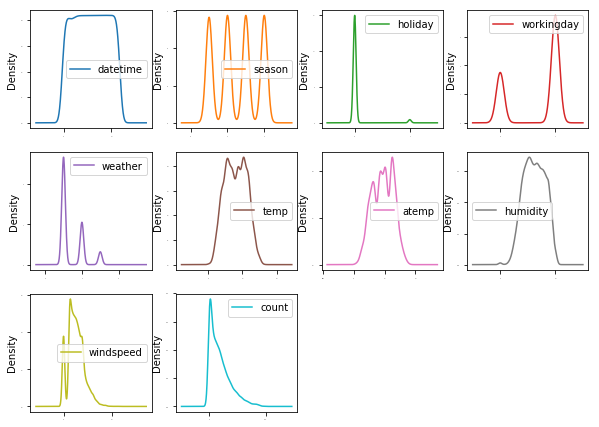

In [14]:
dataset.plot(kind='density',subplots=True,layout=(4,4),sharex=False,sharey=False,legend=True,fontsize=1)
plt.show()

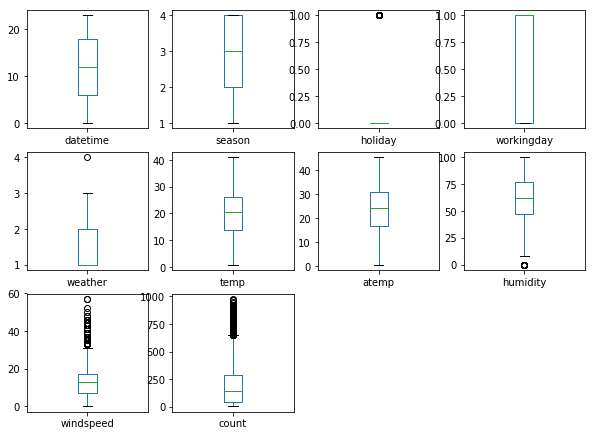

In [15]:
dataset.plot(kind='box',subplots=True,layout=(4,4),sharex=False,sharey=False)
plt.show()

# Split-out validation dataset

In [16]:
array=dataset.values

In [17]:
array

array([[  0.    ,   1.    ,   0.    , ...,  81.    ,   0.    ,  16.    ],
       [  1.    ,   1.    ,   0.    , ...,  80.    ,   0.    ,  40.    ],
       [  2.    ,   1.    ,   0.    , ...,  80.    ,   0.    ,  32.    ],
       ...,
       [ 21.    ,   4.    ,   0.    , ...,  61.    ,  15.0013, 168.    ],
       [ 22.    ,   4.    ,   0.    , ...,  61.    ,   6.0032, 129.    ],
       [ 23.    ,   4.    ,   0.    , ...,  66.    ,   8.9981,  88.    ]])

## Korzystam tylko z danych testowych gdyż nie mam dostępu do "odpowiedzi" do danych testowych z Kaggla

In [18]:
X=array[:,:-1]
Y=array[:,-1]
validation_size=0.2
seed=7
X_train,X_validation,Y_train,Y_validation = train_test_split(X,Y,test_size=validation_size,random_state=seed)

In [19]:
X_train.shape

(8708, 9)

In [20]:
Y_train.shape

(8708,)

In [21]:
X.shape

(10886, 9)

In [22]:
Y.shape

(10886,)

# Test options and eveluation metric

In [23]:
num_folds=10
scoring='neg_mean_squared_error'

# Spot-check algorithms

In [24]:
models=[]
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('EN',ElasticNet()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

# Evaluate models

In [25]:
results=[]
names=[]
for name, model in models:
    kfold=KFold(n_splits=num_folds,random_state=seed,shuffle=True)
    cv_results=cross_val_score(model,X_train,Y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    message="%a: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(message)

'LR': -21898.694250 (1049.588501)
'LASSO': -21887.080156 (1060.980962)
'EN': -21936.933101 (1052.213467)
'KNN': -15818.055508 (974.125929)
'CART': -8922.235766 (423.696624)
'SVR': -34499.888699 (2198.384650)


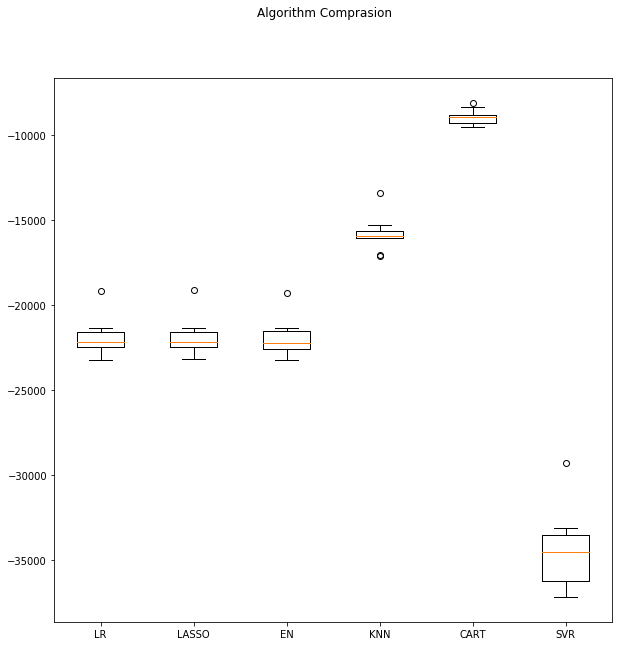

In [26]:
fig=plt.figure()
fig.suptitle('Algorithm Comprasion')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Widzimy,  że najlepsze osiągi daje model CART, dlatego spróbujemy go jeszcze dopasować do modelu

In [27]:
model=DecisionTreeRegressor()
model.fit(X=X_train,y=Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [28]:
predictions=model.predict(X_validation)
print(mean_squared_error(Y_validation,predictions))

9184.960399449035


In [29]:
predictions

array([277., 124., 184., ..., 163.,  74.,  12.])

In [30]:
Y_validation

array([285., 138., 215., ...,  58.,  76.,   4.])

This models dont look nice. We should standardize the data.

# Standardize the data

In [31]:
piplines=[]
piplines.append(('ScaledLR',Pipeline([('Scaler',StandardScaler()),('LR',LinearRegression())])))
piplines.append(('ScaledLASSO',Pipeline([('Scaler',StandardScaler()),('LASSO',Lasso())])))
piplines.append(('ScaledEN',Pipeline([('Scaler',StandardScaler()),('EN',ElasticNet())])))
piplines.append(('ScaledKNN',Pipeline([('Scaler',StandardScaler()),('KNN',KNeighborsRegressor())])))
piplines.append(('ScaledCART',Pipeline([('Scaler',StandardScaler()),('CART',DecisionTreeRegressor())])))
piplines.append(('ScaledSVR',Pipeline([('Scaler',StandardScaler()),('SVR',SVR())])))

results=[]
names=[]
for name, model in piplines:
    kfold=KFold(n_splits=num_folds,random_state=seed,shuffle=True)
    cv_results=cross_val_score(model,X_train,Y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    message="%a: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(message)




'ScaledLR': -21898.694250 (1049.588501)
'ScaledLASSO': -21895.584944 (1053.275361)
'ScaledEN': -22536.531118 (1061.807631)
'ScaledKNN': -11839.255028 (762.649234)
'ScaledCART': -9007.443616 (453.336938)
'ScaledSVR': -22177.324622 (1719.631824)


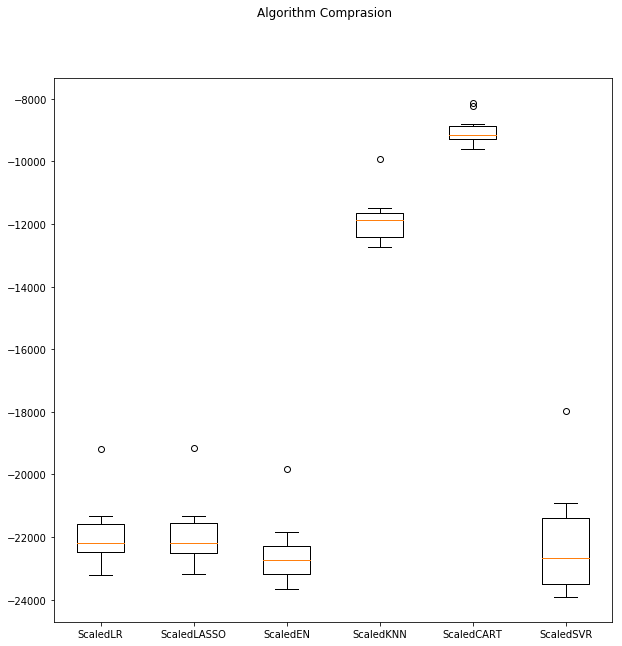

In [32]:
fig=plt.figure()
fig.suptitle('Algorithm Comprasion')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Tuning ScaledCART

In [33]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 4000, num = 10)]
# Number of features to consider at every split
splitter = ['best','random']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 150, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,3,7,15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8,12]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
               'splitter': splitter,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
print(random_grid)

{'splitter': ['best', 'random'], 'max_depth': [2, 16, 31, 46, 61, 76, 90, 105, 120, 135, 150, None], 'min_samples_split': [2, 5, 10, 3, 7, 15], 'min_samples_leaf': [1, 2, 4, 6, 8, 12]}


In [34]:
CART = DecisionTreeRegressor()
CART_random = RandomizedSearchCV(estimator = CART, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)

CART_random.fit(X_train,Y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] splitter=best, min_samples_split=3, min_samples_leaf=8, max_depth=31 
[CV] splitter=best, min_samples_split=3, min_samples_leaf=8, max_depth=31 
[CV] splitter=best, min_samples_split=3, min_samples_leaf=8, max_depth=31 
[CV] splitter=best, min_samples_split=3, min_samples_leaf=8, max_depth=31 
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=8, max_depth=31, total=   0.0s
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=8, max_depth=31, total=   0.0s
[CV] splitter=best, min_samples_split=3, min_samples_leaf=8, max_depth=31 
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=8, max_depth=31, total=   0.1s
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=8, max_depth=31, total=   0.0s
[CV] splitter=best, min_samples_split=3, min_samples_leaf=8, max_depth=31 
[CV] splitter=best, min_samples_split=3, min_samples_leaf=8, max_depth=31 
[CV] splitter=best, min_samples_split=3, min_sampl

[CV] splitter=random, min_samples_split=15, min_samples_leaf=2, max_depth=2 
[CV] splitter=random, min_samples_split=7, min_samples_leaf=2, max_depth=61 
[CV] splitter=random, min_samples_split=15, min_samples_leaf=1, max_depth=61 
[CV]  splitter=random, min_samples_split=15, min_samples_leaf=1, max_depth=61, total=   0.0s
[CV] splitter=random, min_samples_split=15, min_samples_leaf=1, max_depth=61 
[CV]  splitter=random, min_samples_split=15, min_samples_leaf=2, max_depth=2, total=   0.0s
[CV]  splitter=random, min_samples_split=15, min_samples_leaf=1, max_depth=61, total=   0.0s
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=2, max_depth=61, total=   0.0s
[CV]  splitter=random, min_samples_split=15, min_samples_leaf=1, max_depth=61, total=   0.0s
[CV] splitter=random, min_samples_split=15, min_samples_leaf=1, max_depth=61 
[CV] splitter=random, min_samples_split=15, min_samples_leaf=1, max_depth=61 
[CV] splitter=random, min_samples_split=10, min_samples_leaf=2, max_dep

[CV]  splitter=random, min_samples_split=2, min_samples_leaf=8, max_depth=120, total=   0.0s
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=4, max_depth=76, total=   0.0s
[CV] splitter=random, min_samples_split=2, min_samples_leaf=8, max_depth=120 
[CV]  splitter=random, min_samples_split=2, min_samples_leaf=8, max_depth=120, total=   0.0s
[CV] splitter=random, min_samples_split=7, min_samples_leaf=4, max_depth=76 
[CV]  splitter=random, min_samples_split=2, min_samples_leaf=8, max_depth=120, total=   0.0s
[CV] splitter=random, min_samples_split=7, min_samples_leaf=4, max_depth=76 
[CV]  splitter=random, min_samples_split=2, min_samples_leaf=8, max_depth=120, total=   0.0s
[CV] splitter=random, min_samples_split=2, min_samples_leaf=8, max_depth=120 
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=4, max_depth=76, total=   0.0s
[CV] splitter=random, min_samples_split=7, min_samples_leaf=4, max_depth=76 
[CV] splitter=random, min_samples_split=7, min_samples_le

[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    1.5s


[CV]  splitter=random, min_samples_split=3, min_samples_leaf=8, max_depth=120, total=   0.0s
[CV] splitter=best, min_samples_split=7, min_samples_leaf=4, max_depth=90 
[CV]  splitter=best, min_samples_split=7, min_samples_leaf=4, max_depth=90, total=   0.0s
[CV] splitter=random, min_samples_split=3, min_samples_leaf=8, max_depth=120 
[CV] splitter=best, min_samples_split=7, min_samples_leaf=4, max_depth=90 
[CV]  splitter=best, min_samples_split=7, min_samples_leaf=4, max_depth=90, total=   0.1s
[CV]  splitter=random, min_samples_split=3, min_samples_leaf=8, max_depth=120, total=   0.0s
[CV] splitter=best, min_samples_split=7, min_samples_leaf=4, max_depth=90 
[CV]  splitter=best, min_samples_split=7, min_samples_leaf=4, max_depth=90, total=   0.0s
[CV] splitter=best, min_samples_split=7, min_samples_leaf=4, max_depth=90 
[CV] splitter=best, min_samples_split=15, min_samples_leaf=4, max_depth=135 
[CV]  splitter=best, min_samples_split=7, min_samples_leaf=4, max_depth=90, total=   0.0s

[CV] splitter=best, min_samples_split=7, min_samples_leaf=12, max_depth=135 
[CV] splitter=random, min_samples_split=7, min_samples_leaf=8, max_depth=None 
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=8, max_depth=None, total=   0.0s
[CV] splitter=best, min_samples_split=7, min_samples_leaf=12, max_depth=135 
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=8, max_depth=None, total=   0.0s
[CV] splitter=random, min_samples_split=7, min_samples_leaf=8, max_depth=None 
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=8, max_depth=None, total=   0.0s
[CV]  splitter=best, min_samples_split=7, min_samples_leaf=12, max_depth=135, total=   0.1s
[CV] splitter=best, min_samples_split=7, min_samples_leaf=12, max_depth=135 
[CV]  splitter=best, min_samples_split=7, min_samples_leaf=12, max_depth=135, total=   0.0s
[CV] splitter=best, min_samples_split=2, min_samples_leaf=4, max_depth=16 
[CV] splitter=best, min_samples_split=7, min_samples_leaf=12, max_dept

[CV] splitter=random, min_samples_split=10, min_samples_leaf=1, max_depth=120 
[CV] splitter=best, min_samples_split=7, min_samples_leaf=12, max_depth=90 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=1, max_depth=120, total=   0.0s
[CV] splitter=random, min_samples_split=10, min_samples_leaf=1, max_depth=120 
[CV]  splitter=best, min_samples_split=7, min_samples_leaf=12, max_depth=90, total=   0.0s
[CV]  splitter=best, min_samples_split=7, min_samples_leaf=12, max_depth=90, total=   0.0s
[CV] splitter=best, min_samples_split=7, min_samples_leaf=12, max_depth=90 
[CV] splitter=random, min_samples_split=10, min_samples_leaf=1, max_depth=120 
[CV]  splitter=best, min_samples_split=7, min_samples_leaf=12, max_depth=90, total=   0.0s
[CV] splitter=random, min_samples_split=10, min_samples_leaf=1, max_depth=120 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=1, max_depth=120, total=   0.0s
[CV] splitter=random, min_samples_split=10, min_samples_leaf=1, max_dep

[CV] splitter=random, min_samples_split=5, min_samples_leaf=8, max_depth=76 
[CV]  splitter=best, min_samples_split=15, min_samples_leaf=4, max_depth=46, total=   0.0s
[CV] splitter=best, min_samples_split=15, min_samples_leaf=4, max_depth=46 
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=8, max_depth=76, total=   0.0s
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=8, max_depth=76, total=   0.0s
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=8, max_depth=76, total=   0.0s
[CV] splitter=random, min_samples_split=5, min_samples_leaf=8, max_depth=76 
[CV] splitter=best, min_samples_split=15, min_samples_leaf=4, max_depth=46 
[CV] splitter=random, min_samples_split=5, min_samples_leaf=8, max_depth=76 
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=8, max_depth=76, total=   0.0s
[CV] splitter=best, min_samples_split=15, min_samples_leaf=4, max_depth=46 
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=8, max_depth=76, tota

[CV] splitter=best, min_samples_split=15, min_samples_leaf=8, max_depth=61 
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=None, total=   0.1s
[CV] splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=None 
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=None, total=   0.0s
[CV] splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=None 
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=None, total=   0.0s
[CV] splitter=random, min_samples_split=5, min_samples_leaf=1, max_depth=76 
[CV]  splitter=best, min_samples_split=15, min_samples_leaf=8, max_depth=61, total=   0.1s
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=None, total=   0.0s
[CV] splitter=random, min_samples_split=5, min_samples_leaf=1, max_depth=76 
[CV] splitter=random, min_samples_split=5, min_samples_leaf=1, max_depth=76 
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=None, to

[CV]  splitter=random, min_samples_split=15, min_samples_leaf=2, max_depth=46, total=   0.0s
[CV] splitter=random, min_samples_split=15, min_samples_leaf=2, max_depth=46 
[CV]  splitter=best, min_samples_split=10, min_samples_leaf=12, max_depth=16, total=   0.1s
[CV] splitter=random, min_samples_split=15, min_samples_leaf=2, max_depth=46 
[CV] splitter=random, min_samples_split=3, min_samples_leaf=12, max_depth=16 
[CV] splitter=random, min_samples_split=3, min_samples_leaf=12, max_depth=16 
[CV]  splitter=random, min_samples_split=15, min_samples_leaf=2, max_depth=46, total=   0.0s
[CV]  splitter=random, min_samples_split=15, min_samples_leaf=2, max_depth=46, total=   0.0s
[CV] splitter=random, min_samples_split=15, min_samples_leaf=2, max_depth=46 
[CV]  splitter=random, min_samples_split=3, min_samples_leaf=12, max_depth=16, total=   0.0s
[CV] splitter=random, min_samples_split=3, min_samples_leaf=12, max_depth=16 
[CV]  splitter=random, min_samples_split=15, min_samples_leaf=2, max

[CV]  splitter=random, min_samples_split=10, min_samples_leaf=2, max_depth=76, total=   0.0s
[CV] splitter=random, min_samples_split=10, min_samples_leaf=2, max_depth=76 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=2, max_depth=76, total=   0.0s
[CV] splitter=random, min_samples_split=10, min_samples_leaf=2, max_depth=76 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=2, max_depth=76, total=   0.0s
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=12, max_depth=31, total=   0.0s
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=2, max_depth=76, total=   0.0s
[CV] splitter=random, min_samples_split=10, min_samples_leaf=12, max_depth=31 
[CV] splitter=random, min_samples_split=10, min_samples_leaf=2, max_depth=76 
[CV] splitter=random, min_samples_split=10, min_samples_leaf=2, max_depth=76 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=2, max_depth=76, total=   0.0s
[CV] splitter=best, min_samples_split=5, min_sampl

[CV]  splitter=random, min_samples_split=5, min_samples_leaf=6, max_depth=2, total=   0.0s
[CV] splitter=random, min_samples_split=5, min_samples_leaf=6, max_depth=2 
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=6, max_depth=2, total=   0.0s
[CV] splitter=random, min_samples_split=5, min_samples_leaf=2, max_depth=76 
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=12, max_depth=31, total=   0.0s
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=2, max_depth=76, total=   0.0s
[CV] splitter=random, min_samples_split=5, min_samples_leaf=2, max_depth=76 
[CV] splitter=random, min_samples_split=2, min_samples_leaf=4, max_depth=120 
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=2, max_depth=76, total=   0.0s
[CV] splitter=random, min_samples_split=5, min_samples_leaf=2, max_depth=76 
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=2, max_depth=76, total=   0.0s
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=2, ma

[CV]  splitter=best, min_samples_split=3, min_samples_leaf=4, max_depth=2, total=   0.0s
[CV] splitter=best, min_samples_split=3, min_samples_leaf=4, max_depth=2 
[CV] splitter=best, min_samples_split=10, min_samples_leaf=4, max_depth=46 
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=4, max_depth=2, total=   0.0s
[CV] splitter=random, min_samples_split=7, min_samples_leaf=12, max_depth=135 
[CV]  splitter=best, min_samples_split=10, min_samples_leaf=4, max_depth=46, total=   0.1s
[CV]  splitter=best, min_samples_split=10, min_samples_leaf=4, max_depth=46, total=   0.1s
[CV] splitter=best, min_samples_split=10, min_samples_leaf=4, max_depth=46 
[CV]  splitter=best, min_samples_split=10, min_samples_leaf=4, max_depth=46, total=   0.0s
[CV] splitter=best, min_samples_split=10, min_samples_leaf=4, max_depth=46 
[CV] splitter=best, min_samples_split=10, min_samples_leaf=4, max_depth=46 
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=12, max_depth=135, total=   0.0

[CV] splitter=random, min_samples_split=7, min_samples_leaf=12, max_depth=31 
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=12, max_depth=31, total=   0.0s
[CV] splitter=best, min_samples_split=7, min_samples_leaf=8, max_depth=76 
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=12, max_depth=31, total=   0.0s
[CV] splitter=best, min_samples_split=7, min_samples_leaf=8, max_depth=135 
[CV] splitter=best, min_samples_split=7, min_samples_leaf=8, max_depth=76 
[CV] splitter=random, min_samples_split=7, min_samples_leaf=12, max_depth=31 
[CV]  splitter=best, min_samples_split=7, min_samples_leaf=8, max_depth=76, total=   0.0s
[CV] splitter=best, min_samples_split=7, min_samples_leaf=8, max_depth=76 
[CV]  splitter=best, min_samples_split=7, min_samples_leaf=8, max_depth=135, total=   0.0s
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=12, max_depth=31, total=   0.0s
[CV] splitter=best, min_samples_split=7, min_samples_leaf=8, max_depth=135 
[CV] sp

[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    8.0s


[CV] splitter=random, min_samples_split=15, min_samples_leaf=4, max_depth=90 
[CV] splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=120 
[CV] splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=120 
[CV]  splitter=random, min_samples_split=15, min_samples_leaf=4, max_depth=90, total=   0.0s
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=120, total=   0.1s
[CV] splitter=random, min_samples_split=15, min_samples_leaf=4, max_depth=90 
[CV] splitter=random, min_samples_split=15, min_samples_leaf=4, max_depth=90 
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=120, total=   0.0s
[CV]  splitter=random, min_samples_split=15, min_samples_leaf=4, max_depth=90, total=   0.0s
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=120, total=   0.1s
[CV] splitter=random, min_samples_split=15, min_samples_leaf=4, max_depth=90 
[CV] splitter=best, min_samples_split=5, min_samples_leaf=4, max_depth=120 
[

[CV] splitter=best, min_samples_split=3, min_samples_leaf=12, max_depth=2 
[CV]  splitter=random, min_samples_split=3, min_samples_leaf=12, max_depth=None, total=   0.0s
[CV]  splitter=best, min_samples_split=3, min_samples_leaf=12, max_depth=2, total=   0.0s
[CV]  splitter=random, min_samples_split=3, min_samples_leaf=12, max_depth=None, total=   0.0s
[CV] splitter=random, min_samples_split=3, min_samples_leaf=12, max_depth=None 
[CV]  splitter=random, min_samples_split=3, min_samples_leaf=12, max_depth=None, total=   0.0s
[CV] splitter=random, min_samples_split=3, min_samples_leaf=12, max_depth=None 
[CV]  splitter=random, min_samples_split=3, min_samples_leaf=12, max_depth=None, total=   0.0s
[CV] splitter=random, min_samples_split=5, min_samples_leaf=2, max_depth=120 
[CV]  splitter=random, min_samples_split=3, min_samples_leaf=12, max_depth=None, total=   0.0s
[CV] splitter=random, min_samples_split=5, min_samples_leaf=2, max_depth=120 
[CV] splitter=random, min_samples_split=3, m

[CV] splitter=best, min_samples_split=2, min_samples_leaf=12, max_depth=120 
[CV]  splitter=best, min_samples_split=15, min_samples_leaf=1, max_depth=90, total=   0.0s
[CV] splitter=best, min_samples_split=15, min_samples_leaf=1, max_depth=90 
[CV]  splitter=best, min_samples_split=15, min_samples_leaf=1, max_depth=90, total=   0.0s
[CV] splitter=best, min_samples_split=15, min_samples_leaf=1, max_depth=90 
[CV] splitter=best, min_samples_split=15, min_samples_leaf=1, max_depth=90 
[CV]  splitter=best, min_samples_split=2, min_samples_leaf=12, max_depth=120, total=   0.0s
[CV]  splitter=best, min_samples_split=15, min_samples_leaf=1, max_depth=90, total=   0.0s
[CV] splitter=best, min_samples_split=15, min_samples_leaf=1, max_depth=90 
[CV] splitter=best, min_samples_split=2, min_samples_leaf=12, max_depth=120 
[CV]  splitter=best, min_samples_split=15, min_samples_leaf=1, max_depth=90, total=   0.0s
[CV]  splitter=best, min_samples_split=15, min_samples_leaf=1, max_depth=90, total=   

[CV] splitter=best, min_samples_split=5, min_samples_leaf=8, max_depth=None 
[CV] splitter=best, min_samples_split=10, min_samples_leaf=6, max_depth=150 
[CV]  splitter=best, min_samples_split=10, min_samples_leaf=6, max_depth=150, total=   0.0s
[CV] splitter=best, min_samples_split=10, min_samples_leaf=6, max_depth=150 
[CV] splitter=best, min_samples_split=10, min_samples_leaf=6, max_depth=150 
[CV]  splitter=best, min_samples_split=10, min_samples_leaf=6, max_depth=150, total=   0.0s
[CV]  splitter=best, min_samples_split=10, min_samples_leaf=6, max_depth=150, total=   0.0s
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=8, max_depth=None, total=   0.1s
[CV] splitter=best, min_samples_split=10, min_samples_leaf=6, max_depth=150 
[CV] splitter=best, min_samples_split=5, min_samples_leaf=8, max_depth=None 
[CV]  splitter=best, min_samples_split=10, min_samples_leaf=6, max_depth=150, total=   0.0s
[CV]  splitter=best, min_samples_split=10, min_samples_leaf=6, max_depth=150, 

[CV] splitter=random, min_samples_split=7, min_samples_leaf=8, max_depth=120 
[CV] splitter=random, min_samples_split=5, min_samples_leaf=12, max_depth=2 
[CV] splitter=random, min_samples_split=5, min_samples_leaf=12, max_depth=2 
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=12, max_depth=2, total=   0.0s
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=12, max_depth=2, total=   0.0s
[CV] splitter=random, min_samples_split=5, min_samples_leaf=12, max_depth=2 
[CV] splitter=random, min_samples_split=5, min_samples_leaf=12, max_depth=2 
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=12, max_depth=2, total=   0.0s
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=12, max_depth=2, total=   0.0s
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=8, max_depth=120, total=   0.0s
[CV]  splitter=random, min_samples_split=5, min_samples_leaf=12, max_depth=2, total=   0.0s
[CV] splitter=best, min_samples_split=15, min_samples_leaf=12

[CV] splitter=random, min_samples_split=10, min_samples_leaf=12, max_depth=2 
[CV] splitter=random, min_samples_split=10, min_samples_leaf=12, max_depth=2 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=12, max_depth=2, total=   0.0s
[CV]  splitter=best, min_samples_split=2, min_samples_leaf=4, max_depth=135, total=   0.0s
[CV] splitter=best, min_samples_split=2, min_samples_leaf=4, max_depth=135 
[CV]  splitter=random, min_samples_split=10, min_samples_leaf=12, max_depth=2, total=   0.0s
[CV] splitter=best, min_samples_split=2, min_samples_leaf=4, max_depth=135 
[CV] splitter=best, min_samples_split=2, min_samples_leaf=8, max_depth=16 
[CV]  splitter=best, min_samples_split=2, min_samples_leaf=4, max_depth=135, total=   0.1s
[CV] splitter=best, min_samples_split=2, min_samples_leaf=4, max_depth=135 
[CV]  splitter=best, min_samples_split=2, min_samples_leaf=4, max_depth=135, total=   0.0s
[CV] splitter=best, min_samples_split=2, min_samples_leaf=4, max_depth=135 
[CV]  

[CV] splitter=random, min_samples_split=7, min_samples_leaf=1, max_depth=105 
[CV] splitter=best, min_samples_split=5, min_samples_leaf=8, max_depth=46 
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=8, max_depth=46, total=   0.0s
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=8, max_depth=46, total=   0.0s
[CV] splitter=random, min_samples_split=7, min_samples_leaf=1, max_depth=105 
[CV] splitter=random, min_samples_split=7, min_samples_leaf=1, max_depth=105 
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=1, max_depth=105, total=   0.0s
[CV] splitter=random, min_samples_split=7, min_samples_leaf=1, max_depth=105 
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=8, max_depth=46, total=   0.0s
[CV]  splitter=random, min_samples_split=7, min_samples_leaf=1, max_depth=105, total=   0.0s
[CV] splitter=best, min_samples_split=5, min_samples_leaf=8, max_depth=46 
[CV] splitter=random, min_samples_split=7, min_samples_leaf=1, max_depth=105 
[CV]

[CV] splitter=random, min_samples_split=3, min_samples_leaf=2, max_depth=105 
[CV] splitter=random, min_samples_split=3, min_samples_leaf=2, max_depth=105 
[CV]  splitter=best, min_samples_split=15, min_samples_leaf=2, max_depth=150, total=   0.0s
[CV]  splitter=random, min_samples_split=3, min_samples_leaf=2, max_depth=105, total=   0.0s
[CV] splitter=best, min_samples_split=5, min_samples_leaf=6, max_depth=16 
[CV]  splitter=random, min_samples_split=3, min_samples_leaf=2, max_depth=105, total=   0.0s
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=6, max_depth=16, total=   0.0s
[CV] splitter=random, min_samples_split=3, min_samples_leaf=2, max_depth=105 
[CV] splitter=random, min_samples_split=3, min_samples_leaf=2, max_depth=105 
[CV] splitter=best, min_samples_split=5, min_samples_leaf=6, max_depth=16 
[CV]  splitter=best, min_samples_split=5, min_samples_leaf=6, max_depth=16, total=   0.0s
[CV] splitter=best, min_samples_split=5, min_samples_leaf=6, max_depth=16 
[CV] 

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.5s finished


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'splitter': ['best', 'random'], 'max_depth': [2, 16, 31, 46, 61, 76, 90, 105, 120, 135, 150, None], 'min_samples_split': [2, 5, 10, 3, 7, 15], 'min_samples_leaf': [1, 2, 4, 6, 8, 12]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [35]:
CART_random.best_params_

{'splitter': 'best',
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_depth': 16}

Best parameters for this model:
{'splitter': 'best',
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_depth': 16}

# Evaluate tuned model

In [36]:
models=[]
models.append(('CART',DecisionTreeRegressor(splitter='best',min_samples_split=2,min_samples_leaf=8,max_depth=16)))
results=[]
names=[]
for name, model in models:
    kfold=KFold(n_splits=num_folds,random_state=seed,shuffle=True)
    cv_results=cross_val_score(model,X_train,Y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    message="%a: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(message)

'CART': -6465.841197 (595.955959)


In [37]:
model=DecisionTreeRegressor(splitter='best',min_samples_split=7,min_samples_leaf=12,max_depth=90)
results=[]
model.fit(X=X_train,y=Y_train)
predictions=model.predict(X_validation)
print(mean_squared_error(Y_validation,predictions))

6131.00464999717


Model get much bether result then with defult parameters

# Ensemble Methods

In [38]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [39]:
ensembles=[]
ensembles.append(('ScaledAB',Pipeline([('Scaler',StandardScaler()),('AB',AdaBoostRegressor())])))
ensembles.append(('ScaledGBM',Pipeline([('Scaler',StandardScaler()),('GBM',GradientBoostingRegressor())])))
ensembles.append(('ScaledRF',Pipeline([('Scaler',StandardScaler()),('RF',RandomForestRegressor())])))
ensembles.append(('ScaledET',Pipeline([('Scaler',StandardScaler()),('ET',ExtraTreesRegressor())])))

results=[]
names=[]
for name, model in ensembles:
    kfold=KFold(n_splits=num_folds,random_state=seed,shuffle=True)
    cv_results=cross_val_score(model,X_train,Y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    message="%a: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(message)

'ScaledAB': -12729.891296 (646.969278)
'ScaledGBM': -6973.664706 (479.994406)
'ScaledRF': -5537.702428 (434.494903)
'ScaledET': -5643.769409 (568.379900)


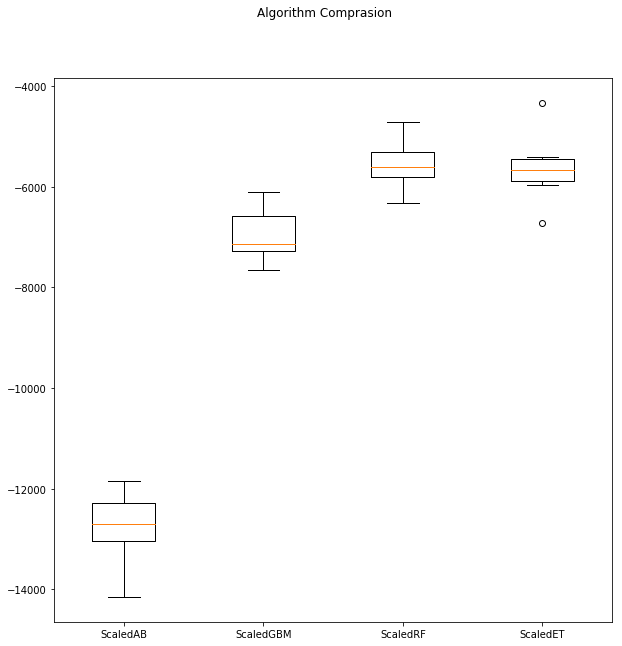

In [40]:
fig=plt.figure()
fig.suptitle('Algorithm Comprasion')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Tunning RF

In [41]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

for i in random_grid:
    print(i,random_grid[i])


n_estimators [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
max_features ['auto', 'sqrt']
max_depth [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]
min_samples_split [2, 5, 10]
min_samples_leaf [1, 2, 4]
bootstrap [True, False]


In [42]:
#run about 30minuts
RF = RandomForestRegressor()
RF_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
RF_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   4.2s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   4.3s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 


[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=  12.1s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=  11.8s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  38.5s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  37.5s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=  18.6s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators

[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total=  23.9s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=  12.4s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=  20.6s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=  38.1s
[CV] n_estimators=

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   6.9s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   7.0s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=  10.2s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=  15.9s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800,

[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   6.2s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=  12.9s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=  13.1s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=  13.6s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=400, 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.7min


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  25.8s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  25.8s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=  54.9s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=  54.5s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimat

[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total=  26.4s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=  33.6s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=  14.8s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=  14.4s
[CV] n_estima

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=  12.6s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   4.6s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   4.7s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   4.7s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=

[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=  21.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   4.1s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   7.4s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   7.4s
[CV] n_estimators=1600,

[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   5.1s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=  21.1s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   5.1s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=  21.4s
[CV] n_estimators=2000

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 25.8min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [43]:
RF_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [45]:
models=[]
models.append(('RF',RandomForestRegressor(
                                random_state=seed,
                                n_estimators=2000,
                                max_features='auto',
                                max_depth=90,
                                min_samples_split=2,
                                min_samples_leaf=2,
                                bootstrap=True
)))
results=[]
names=[]
for name, model in models:
    kfold=KFold(n_splits=num_folds,random_state=seed,shuffle=True)
    cv_results=cross_val_score(model,X_train,Y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    message="%a: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(message)

'RF': -4984.960257 (490.671832)


In [46]:
model=RandomForestRegressor(
                                random_state=seed,
                                n_estimators=2000,
                                max_features='auto',
                                max_depth=90,
                                min_samples_split=2,
                                min_samples_leaf=2,
                                bootstrap=True
)
results=[]
model.fit(X=X_train,y=Y_train)
predictions=model.predict(X_validation)
print(mean_squared_error(Y_validation,predictions))

4912.329086748511


In [47]:
scaler=StandardScaler().fit(X_train)
rescaledX=scaler.transform(X_train)
model=RandomForestRegressor(    random_state=seed,
                                n_estimators=2000,
                                max_features='auto',
                                max_depth=90,
                                min_samples_split=2,
                                min_samples_leaf=2,
                                bootstrap=True
)
model.fit(rescaledX,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
           oob_score=False, random_state=7, verbose=0, warm_start=False)

## Znaleźliśmy najlepszy model do naszego problemu. W celu usprawnienia można spróbować znaleźć jeszcze lepsze parametry albo popracować nad danymi. 

In [48]:
rescaledValidationX=scaler.transform(X_validation)
predictions=model.predict(rescaledValidationX)
print(mean_squared_error(Y_validation,predictions))

4912.229967793292


In [49]:
predictions

array([287.35422399, 108.21179912, 219.99130851, ...,  73.70367222,
       103.55877579,  15.47144901])

In [50]:
Y_validation

array([285., 138., 215., ...,  58.,  76.,   4.])

In [51]:
solution={'Y_validation':Y_validation,'predictions':predictions}

In [52]:
sorted_solution=pd.DataFrame(solution).sort_values(by='Y_validation').reset_index(drop=True);sorted_solution

,Y_validation,predictions
0,1.0,3.83
1,1.0,3.47
2,1.0,6.83
3,1.0,3.07
4,1.0,4.88
5,1.0,4.53
6,1.0,3.19
7,1.0,3.58
8,1.0,5.26
9,1.0,4.12


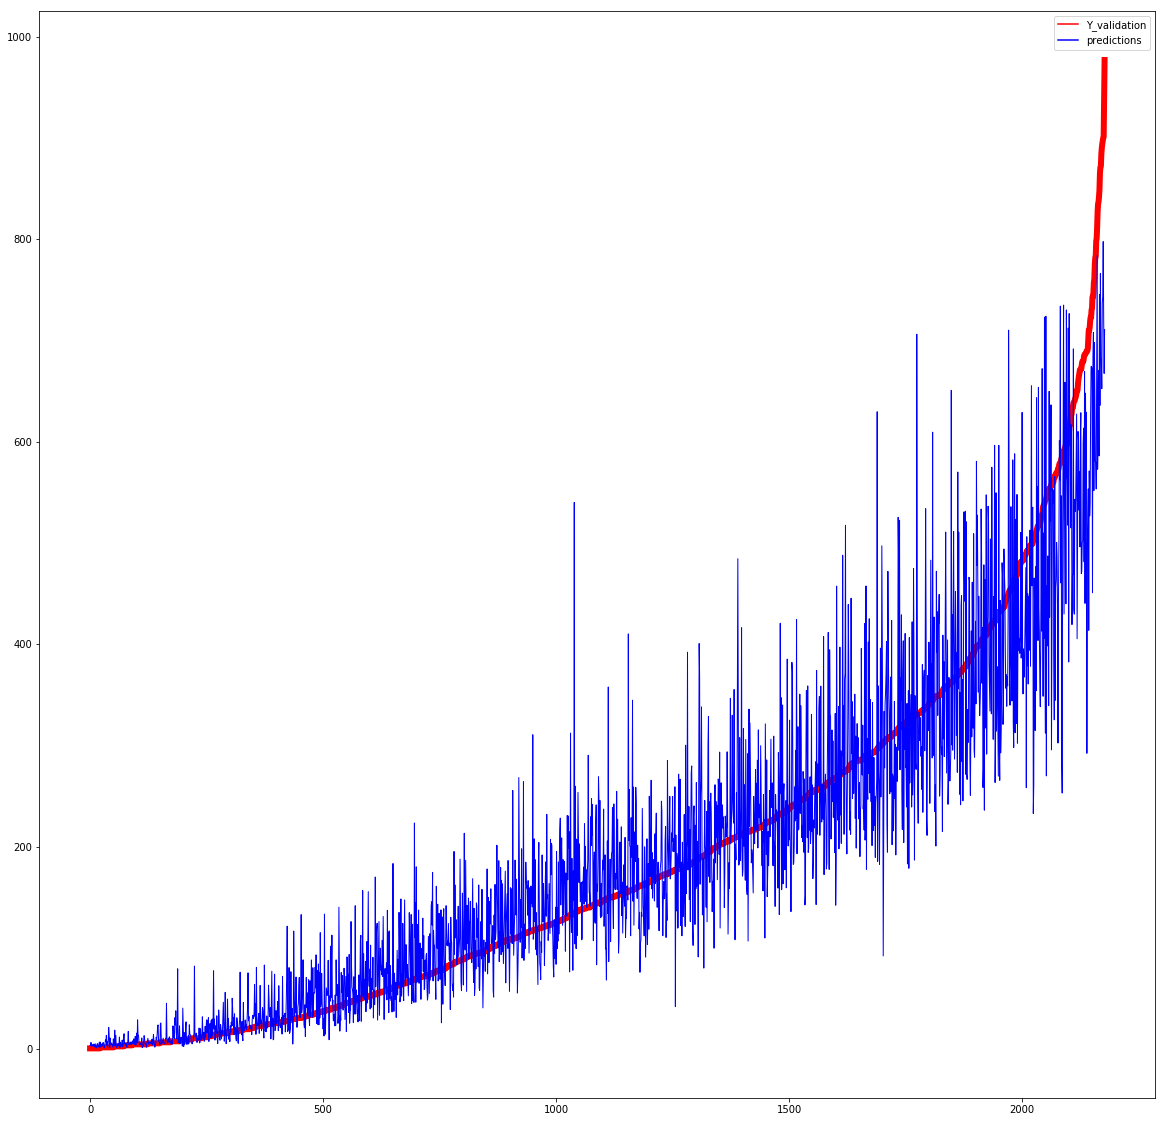

In [53]:
lws = [6, 1]
ax = sorted_solution.plot(legend=True,figsize=[20,20],color=['r','b'])
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=lws[i])

The solution isn't perfect but its the best from tested algorithms

## Jak widać na wykresie, model nie jest idealny, ale najlepszy z dotychczas testowanych.

## Innym interesującym modelem mogła by być sieć neuronowa, jednak nie starczyło mi czasu na przetestowanie takiego rozwiązania.